# Lecture notes for 09 22 2020

# Group/Individual Challenge!

In this directory, I have included a FITS data file containing a continuum image of an HII region, observed at a frequency of $\sim$ 100 GHz. You can read these data into python using the astropy package. 


(1) Measure the peak brightness temperature of the HII region.

(2) Estimate the angular size, and convert it to a radius in parsecs, assuming a distance of 8.1 kpc. 

(3) Use the observed brightness temperature, and assuming $T_e =8000$ K, estimate the optical depth. At millimeter wavelengths, $\tau$<<1, so (assuming a constant nebula temperature) you can approximate the optical depth from Draine 10.19 as 

$\displaystyle I_\nu = I_{\nu,0}e^{-\tau_\nu} + \left[\frac{j_{ff}}{\kappa_{ff}} \right]\left(1- e^{-\tau_\nu}\right)  = B_\nu(T)\left(1- e^{-\tau_\nu}\right)$

$\tau \sim \displaystyle \frac{I_\nu}{B_\nu(T)} \sim \frac{T_B}{T_e}$

(4) Use Draine equation 10.23 to estimate the peak emission measure (assume pure hydrogen so $n_i = n_p$). 

(5) Using the measured size of the nebula, estimate the electron density $n_e$. 





Set OBSGEO-B to   -23.022886 from OBSGEO-[XYZ].
Set OBSGEO-H to     5053.796 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]


Text(0.05, 0.02, 'Beam size: 2.4" x 1.9"')

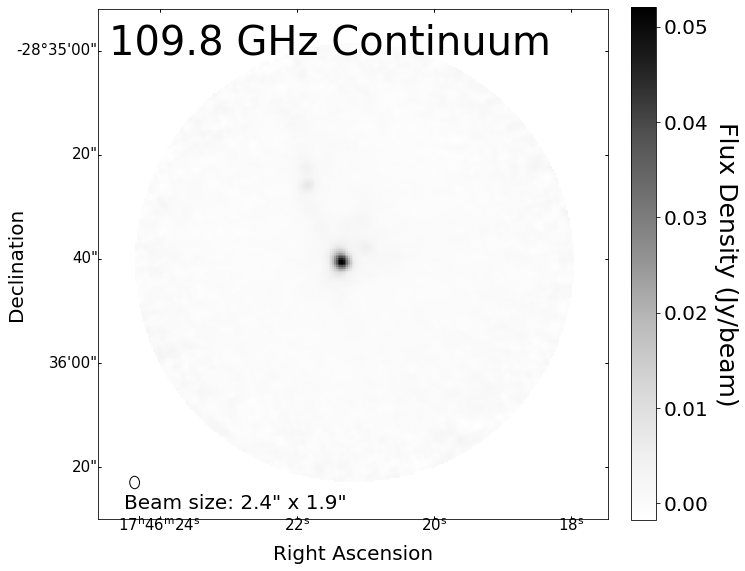

In [1]:

import numpy as np                          # I use this for maths and sometimes arrays.
                                            # "np" is just an abbreviation since we call this package so often!
import pylab                                # I use this for arrays and plotting sometimes
import matplotlib
import matplotlib.pyplot as plt                    # Standard plotting package
import scipy


import astropy.io.fits as fits              # I use this to import FITS images. 
                                            # Astropy should be included in your conda installation
from astropy.wcs import WCS                 # This one helps us add coordinates to images
import matplotlib.patches as patches
from astropy import units as u              # This one helps with unit conversion

plt.rc('font', family='sans-serif')  # Set plot fonts
plt.rc('text', usetex=True)      
plt.rc('text', usetex=False)        # This is a quick fix if you don't have latex on your computer


path = 'support_files/Dust_Ridge_continuum.pbcor.fits'

                                # The fits images we will work with consist of two main parts:
                                # (1) An array of 2-4 dimensions that holds the value of each image pixel 
                                # (2) A "header" which contains a summary of information associated with this array                


image = fits.getdata(path)      # This command reads in the data array part of the fits file
header = fits.getheader(path)   # This command reads in the header
pixel = header['CDELT1']        # The pixel scale of the image
bmaj = header['BMIN']           # Major axis (in degrees) 
bmin = header['BMAJ']           # Minor axis (in degrees)
bpa = header['BPA']
freq = header['RESTFRQ']/1.0e9    
w1 = WCS(header)                # This command grabs information from the header, but focuses just on the
                                # part of the header that tells you how pixel coordinates correspond to 
                                # sky coordinates        
w1 = w1.dropaxis(3)
w1 = w1.dropaxis(2)

image_2D = pylab.squeeze(image) #squeeze gets rid of all axes with length=1.


fig1 = pylab.figure(1,figsize=(10,10))       # We will make this figure #1 and give it a size of 10x10

                                             # We also want to make sure that our image is plotted with sky coordinates
ax1 = pylab.subplot(projection=w1)           # We do this by specifying a projection (the wcs from the previous cell)
RA = ax1.coords[0]
Dec = ax1.coords[1]

im1 = plt.imshow(image_2D,cmap='Greys')     # We have a lot of control over how we plot the image.
                                            # Note that each of these options will plot on top of any 
                                            # previously-displayed image. To display an image as a
                                            # new figure, you need to define a new figure command, 
                                            # with a unique figure number, e.g, fig2 = pylab.figure(2)
                                            
                                            # The options below show other ways to customize this figure 
RA.set_ticks(size=-3)                       # Change the length of the tick marks 
Dec.set_ticks(size=-3)                      # (negative values place ticks inside the bounding box)

pylab.xlabel('Right Ascension',fontsize=20,labelpad=1)                              # Label the x-axis
pylab.ylabel('Declination',fontsize=20,labelpad=0)                                  # Label the y-axis
ax1.tick_params(axis = 'both', which = 'major', labelsize = 15)                     # Increase tick label font
pylab.annotate(s='%1.1f GHz Continuum' %freq,fontsize=40,xy=(0.02,0.91),xycoords="axes fraction")   # Add a label in the figure
cb=pylab.colorbar(im1,fraction=0.046,pad=0.04) # Define a color bar
cb.set_label(label='Flux Density (Jy/beam)',fontsize=25,rotation=270,labelpad=30) # Add a colorbar label
cb.ax.tick_params(which = 'major', labelsize = 20);                                 # Increase colorbar fonts

#Plot the beam
ax1.add_patch(
            patches.Ellipse(
                (20,20),                            # central position to plot
                bmaj/pixel,bmin/pixel,angle=bpa+90, # ellipse parameters
                fill=False,                         # remove background fill
                color='black'
            ))

pylab.annotate(s='Beam size: %1.1f" x %1.1f"' %(bmin*3600,bmaj*3600),fontsize=20,xy=(0.05,0.02),xycoords="axes fraction")



In [2]:
#Measure peak Brightness Temperature

bmin= header['BMAJ']*3600*u.arcsec
bmaj=header['BMIN']*3600*u.arcsec
fwhm_to_sigma = 1./(8*np.log(2))**0.5
beam_area = 2.*np.pi*(bmaj*bmin*fwhm_to_sigma**2)
freq = header['RESTFRQ'] * u.Hz
equiv = u.brightness_temperature(freq)
(u.Jy/beam_area).to(u.K, equivalencies=equiv)  
(u.Jy/beam_area).to(u.K, equivalencies=equiv).value
new_image=image_2D*(u.Jy/beam_area).to(u.K, equivalencies=equiv).value
new_image.shape
Tmax_i= np.nanargmax(new_image)
Tmax_i=np.unravel_index(Tmax_i, new_image.shape) #grabbing coords of the largest value in the image
TB=new_image[Tmax_i]
print(f"Brigthness Temperature = {TB*u.K:0.3} ")

Brigthness Temperature = 1.18 K 


In [3]:
#Estimating Angular Size

D=8.1e3 *u.pc
distance=np.sqrt(beam_area.value/np.pi)
R= distance* D/206265 /2
print(f"Radius = {R:0.3} ")



Radius = 0.025 pc 


In [4]:
#Estimating Optical Depth

Te=8000
tau=TB/Te
k=tau/2/R.value
print(f"Optical depth = {tau:0.2}")


Optical depth = 0.00015


In [5]:
# Estimating Peak Emission Measure

nu=100
EM=tau/(1.091*np.power(TB/1e4,-1.323)*np.power(nu,-2.118))*1e25 * u.cm**-5
print(f"Peak Emission Measure = {EM.to(u.pc/u.cm**6):0.2} ")



Peak Emission Measure = 4.8e+01 pc / cm6 


In [8]:
#Electron Density

n_e = np.sqrt(EM/R)
print(f"n = {n_e.to(u.cm**-3):0.3} ")


n = 43.7 1 / cm3 


We used much the same method as in a previous classwork to convert the image to brightness temp units. We then plucked out the largest value in the array to find the peak brightness temperature. The rest was simply using simple equations to eventually get to the electron density of the HII region. 